In [1]:
%cd ../
%matplotlib inline

/home/eli/AnacondaProjects/HTFATorch


In [2]:
# import dependencies
import logging
import numpy as np

import htfa_torch.tfa as TFA
import htfa_torch.utils as utils

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s',
                            datefmt='%m/%d/%Y %H:%M:%S',
                            level=logging.INFO)

In [4]:
tfa = TFA.TopographicalFactorAnalysis('data/pieman_data/sub-001-task-intact1.nii', num_factors=25)

In [5]:
prior_sample = tfa.sample()

logging.info('Prior Reconstruction Error (Frobenius Norm): %.8e', np.linalg.norm(
    prior_sample['Y0'].value.data.cpu().numpy() - tfa.voxel_activations.numpy()
))

prior_sample

del prior_sample

03/28/2018 12:18:54 Prior Reconstruction Error (Frobenius Norm): 5.34334082e+03


In [6]:
losses = tfa.train(num_steps=200, log_level=logging.INFO, batch_size=tfa.voxel_activations.shape[0], num_particles=4)

03/28/2018 12:18:54 [Epoch 1] (222ms) Posterior free-energy 6.39604480e+09
03/28/2018 12:18:54 [Epoch 2] (235ms) Posterior free-energy 8.89634406e+09
03/28/2018 12:18:54 [Epoch 3] (211ms) Posterior free-energy 6.63051674e+09
03/28/2018 12:18:54 [Epoch 4] (209ms) Posterior free-energy 5.18819789e+09
03/28/2018 12:18:55 [Epoch 5] (207ms) Posterior free-energy 4.00261453e+09
03/28/2018 12:18:55 [Epoch 6] (208ms) Posterior free-energy 4.53264640e+09
03/28/2018 12:18:55 [Epoch 7] (208ms) Posterior free-energy 6.24306995e+09
03/28/2018 12:18:55 [Epoch 8] (230ms) Posterior free-energy 4.17739238e+09
03/28/2018 12:18:56 [Epoch 9] (209ms) Posterior free-energy 2.89211955e+09
03/28/2018 12:18:56 [Epoch 10] (208ms) Posterior free-energy 3.03268429e+09
03/28/2018 12:18:56 [Epoch 11] (231ms) Posterior free-energy 2.79575194e+09
03/28/2018 12:18:56 [Epoch 12] (253ms) Posterior free-energy 2.34806016e+09
03/28/2018 12:18:56 [Epoch 13] (208ms) Posterior free-energy 2.46529562e+09
03/28/2018 12:18:57 [

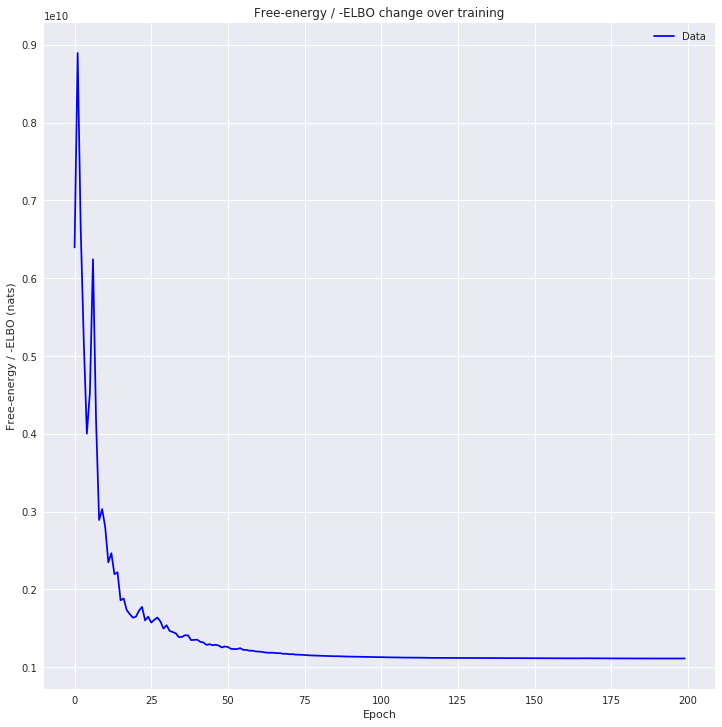

03/28/2018 12:19:37 Reconstruction Error (Frobenius Norm): 4.79566016e+03
03/28/2018 12:19:37 {'weights': array([[-0.04969355,  1.5412817 ,  0.97913456, ...,  0.5370087 ,
        -1.6416724 ,  0.43673158],
       [-0.9192138 ,  0.8188931 ,  1.7997465 , ...,  0.05365229,
         0.0080264 ,  1.2254347 ],
       [-1.8343318 ,  0.28412116,  1.6882343 , ..., -1.3881123 ,
         0.733808  ,  1.8060646 ],
       ...,
       [-3.427858  ,  0.23749335,  1.2394469 , ..., -0.74846834,
         0.21561237,  0.16737528],
       [-3.7200963 ,  0.07989082,  2.392429  , ..., -0.24269044,
        -0.34752518, -1.0035249 ],
       [-5.3091326 ,  0.8494863 ,  4.22046   , ...,  2.11173   ,
         0.30394176, -2.4306333 ]], dtype=float32), 'factors': array([[0.00872962, 0.0091839 , 0.00961243, ..., 0.00798767, 0.00875487,
        0.00916529],
       [0.00159818, 0.00156566, 0.00152344, ..., 0.68240863, 0.70575136,
        0.6675375 ],
       [0.00172026, 0.00172378, 0.00171863, ..., 0.07267521, 0.075

In [7]:
utils.plot_losses(losses)

results = tfa.results()
logging.info(results)

In [8]:
posterior_sample = tfa.sample(posterior_predictive=True)

logging.info('Prior Reconstruction Error (Frobenius Norm): %.8e', np.linalg.norm(
    posterior_sample['Y0'].value.data.cpu().numpy() - tfa.voxel_activations.numpy()
))

posterior_sample

03/28/2018 12:19:39 Prior Reconstruction Error (Frobenius Norm): 4.82622656e+03


Trace{'Weights0': Normal([torch.cuda.FloatTensor of size 1x300x25]), 'FactorCenters0': Normal([torch.cuda.FloatTensor of size 1x25x3]), 'FactorLogWidths0': Normal([torch.cuda.FloatTensor of size 1x25]), 'Y0': Normal([torch.cuda.FloatTensor of size 1x300x94537])}

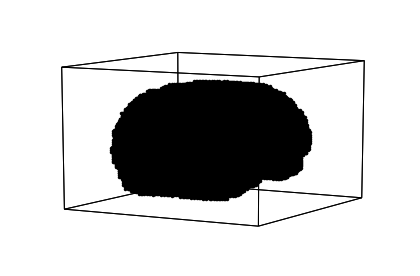

03/28/2018 12:19:39 Reconstruction Error (Frobenius Norm): 4.79540918e+03
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


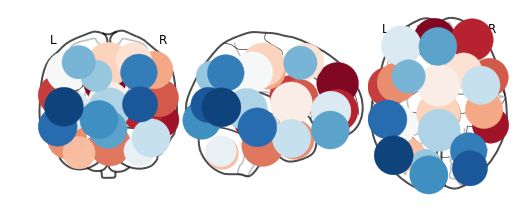

In [9]:
tfa.plot_voxels()
tfa.plot_factor_centers()

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


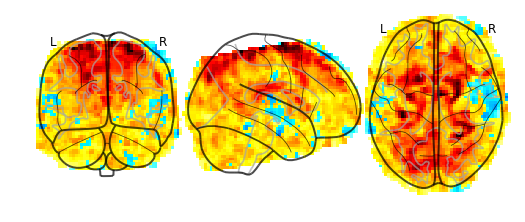

03/28/2018 12:19:40 Reconstruction Error (Frobenius Norm): 4.79563916e+03


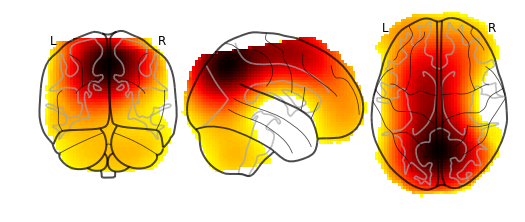

In [10]:
tfa.plot_original_brain()
tfa.plot_reconstruction()

03/28/2018 12:19:52 Reconstruction Error (Frobenius Norm): 4.79585547e+03
/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


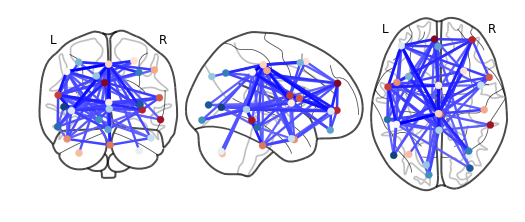

In [11]:
tfa.plot_connectome()